In [ ]:
from astropy.table import Table
import galsim
import galcheat
import numpy as np
import fitsio
import matplotlib.pyplot as plt


# Galaxy density

In [ ]:
cat = Table.read('../OneDegSq.fits')


In [ ]:
# density in arcmin with i < 27 (target depth)
dens = len(cat[cat['i_ab'] < 27]) / (60 * 60)

dens_arcsec = dens / 3600

# corresponding to expected number of galaxies in 88x88 pixels with scale = 0.2 
exp = (dens / (60 * 60)) * 88 * 88 * 0.2 * 0.2

print(dens, exp )


159.97305555555556 13.764792691358025


In [ ]:
# snr of a star with median fwhm = 0.75'' and depth 

from galcheat.utilities import mag2counts, mean_sky_level

lsst = galcheat.get_survey('LSST')
i_filt = lsst.get_filter('i')

sky_level = mean_sky_level(lsst, i_filt).value

i_mag_cut = 27
flux = mag2counts(i_mag_cut, lsst, i_filt).value
star = galsim.Gaussian(fwhm=0.75).withFlux(flux)

# snr 
arr = star.drawImage(scale=0.2).array

np.sqrt(np.sum((arr * arr) / (arr + sky_level)))



4.5988536

In [ ]:
# Probability that there is more than one source per tile
p = dens_arcsec * 4 * 4 * 0.2 * 0.2
p_1 = 1 - (np.exp(-p) + p * np.exp(-p))
p_1


0.00039682066201363053

# Average stellar density LSST

In [ ]:
# we use the `stellar_density_lsst.fits.gz` file to calculate average stellar density
# with clipping min_stellar_density = 2, max_stellar_density = 100 (as in Metadetection for LSST paper)
with fitsio.FITS("../../../data/stellar_density_lsst.fits.gz") as fits:
    densities = fits[1]['I'].read().ravel()

mask = (densities > 2 ) & ( densities < 100)
densities = densities[mask]
densities.shape

(19643,)

In [ ]:
densities.mean() # use this density with magnitudes randomly from `stars_med_june2018.fits` for stars

15.530523

In [ ]:
table = Table.read("../../../data/stars_med_june2018.fits")

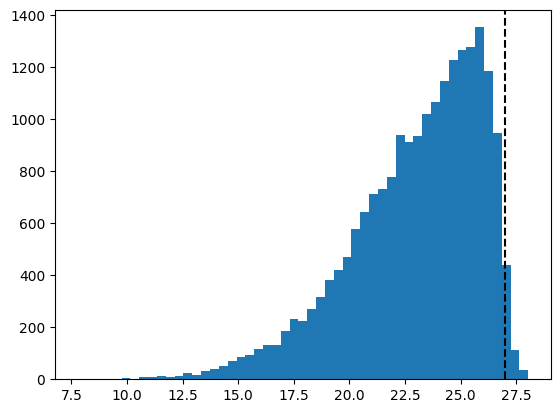

In [ ]:
#==>  ok to make a magnitude cut on 27.0 and still use this average density
plt.hist(table["i_ab"], bins=51)
plt.axvline(27.0, color='k', linestyle='--')